In [86]:
import warnings
warnings.filterwarnings('ignore')

In [96]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import pmdarima as pm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [5]:
from tensorflow.keras.models import load_model

In [63]:
def plot_graph(figsize, values, column_name):
    plt.figure()
    values.plot(figsize = figsize)
    plt.xlabel("Years")
    plt.ylabel(column_name)
    plt.title(f"{column_name} of Gold data")

# Model LTSM

In [50]:
df = pd.read_csv('D:/thuantt2/Document/Big_data_project/data/gold_data.csv')
df.head()

,Date,symbol,Open,High,Low,Close,Adj Close,Volume
0,8/30/2000,GC=F,273.899994,273.899994,273.899994,273.899994,273.899994,0
1,8/31/2000,GC=F,274.799988,278.299988,274.799988,278.299988,278.299988,0
2,9/1/2000,GC=F,277.000000,277.000000,277.000000,277.000000,277.000000,0
3,9/5/2000,GC=F,275.799988,275.799988,275.799988,275.799988,275.799988,2
4,9/6/2000,GC=F,274.200012,274.200012,274.200012,274.200012,274.200012,0


In [51]:
# Get Date & Close columns
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,8/30/2000,273.899994
1,8/31/2000,278.299988
2,9/1/2000,277.000000
3,9/5/2000,275.799988
4,9/6/2000,274.200012


In [52]:
# check Dte type
df.Date.dtype

dtype('O')

In [53]:
# convert Date from string to datetime
df.Date = df.Date.apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))

In [54]:
df.Date.dtype

dtype('<M8[ns]')

In [55]:
# reset index
df.index = df.pop('Date')

In [57]:
df.head()

,Close
Date,
2000-08-30,273.899994
2000-08-31,278.299988
2000-09-01,277.000000
2000-09-05,275.799988
2000-09-06,274.200012


In [58]:
# scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[["Close"]])

In [101]:
scaled_data

array([[ 273.8999939],
       [ 278.2999878],
       [ 277.       ],
       ...,
       [2525.699951 ],
       [2493.800049 ],
       [2529.800049 ]])

- Comment: The data is recorded daily

In [60]:
# Define predictor and dependent variables
# Rule: Get data from 100 days before to predict the next day.
x_data = []
y_data = []
for i in range(100, len(scaled_data)):
    x_data.append(scaled_data[i-100:i])
    y_data.append(scaled_data[i])
x_data, y_data = np.array(x_data), np.array(y_data)

In [61]:
# train-test split: get 80% data for training model and the remain is for testing
splitting_len = int(len(x_data)*0.8)
x_train = x_data[:splitting_len]
y_train = y_data[:splitting_len]

x_test = x_data[splitting_len:]
y_test = y_data[splitting_len:]

In [20]:
len(x_train)

4739

In [21]:
len(x_test)

1185

In [22]:
x_train.shape

(4739, 100, 1)

In [112]:
# define model
model = Sequential([layers.Input((100, 1)), 
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________


In [24]:
# fit model
model.fit(x_train, y_train, batch_size = x_train.shape[1], epochs = 2)

Epoch 1/2
48/48 [==============================] - 4s 44ms/step - loss: 0.0120 - mean_absolute_error: 0.0686
Epoch 2/2
48/48 [==============================] - 2s 41ms/step - loss: 1.3299e-04 - mean_absolute_error: 0.0085


In [27]:
predictions = model.predict(x_test)

38/38 [==============================] - 0s 8ms/step


In [28]:
# inverse prediction & test:
inv_predictions = scaler.inverse_transform(predictions)
inv_y_test = scaler.inverse_transform(y_test)

# calculate the rmse
rmse = np.sqrt(np.mean((inv_predictions - inv_y_test)**2))
rmse

35.77134436847361

In [62]:
# create dataframe
ploting_data = pd.DataFrame({'Original_test_data': inv_y_test.reshape(-1),
    'Predictions': inv_predictions.reshape(-1)},index = df.index[splitting_len+100:])
ploting_data.head()

,Original_test_data,Predictions
Date,,
2019-12-18,1472.599976,1471.352295
2019-12-19,1478.199951,1471.975464
2019-12-20,1474.699951,1473.227539
2019-12-23,1482.500000,1473.896484
2019-12-24,1499.099976,1475.477539


<Figure size 640x480 with 0 Axes>

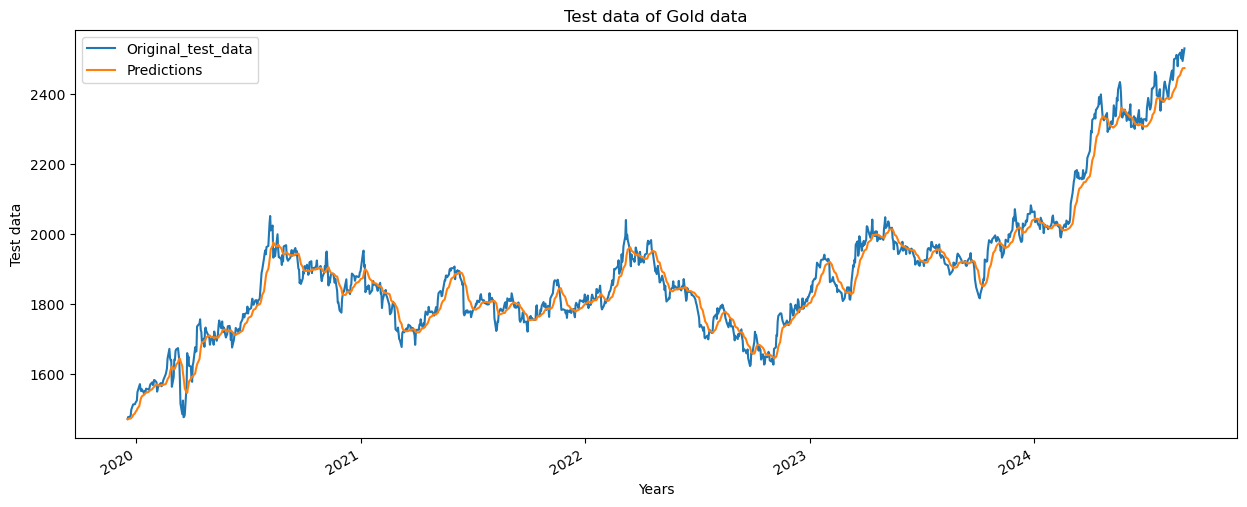

In [65]:
plot_graph((15,6), ploting_data, 'Test data');

# Model ARIMA

### Check for stationarity of time series

In [71]:
r_t = np.log(df['Close']/df['Close'].shift(1))
mean = np.nanmean(r_t)

In [72]:
r_t

Date
2000-08-30         NaN
2000-08-31    0.015937
2000-09-01   -0.004682
2000-09-05   -0.004342
2000-09-06   -0.005818
                ...   
2024-08-27   -0.000675
2024-08-28   -0.005980
2024-08-29    0.009828
2024-08-30   -0.012711
2024-09-02    0.014333
Name: Close, Length: 6024, dtype: float64

In [73]:
mean

0.0003691071712741874

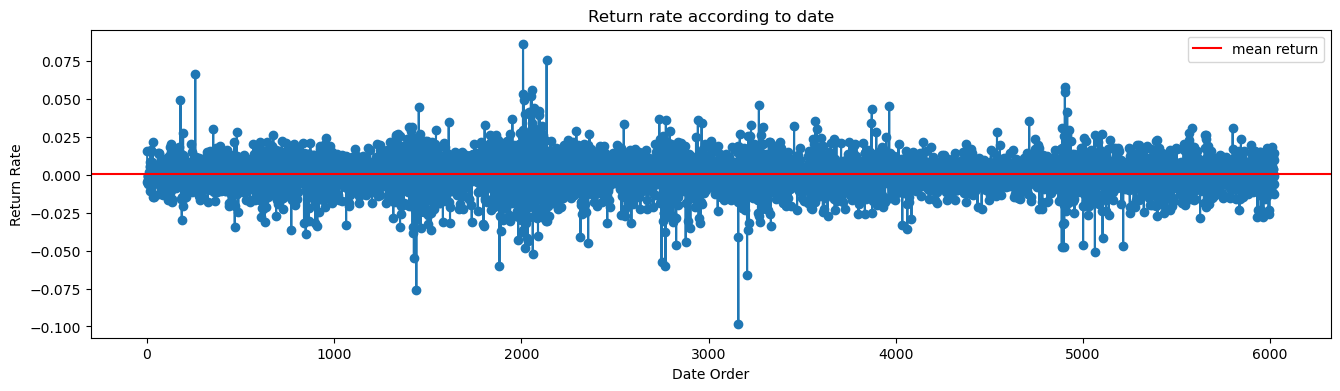

In [74]:
plt.figure(figsize=(16, 4))
plt.plot(np.arange(r_t.shape[0]), r_t, '-o')
plt.axhline(y=mean, label='mean return', c='red')
plt.title('Return rate according to date')
plt.xlabel('Date Order')
plt.ylabel('Return Rate')
plt.legend()
plt.show()

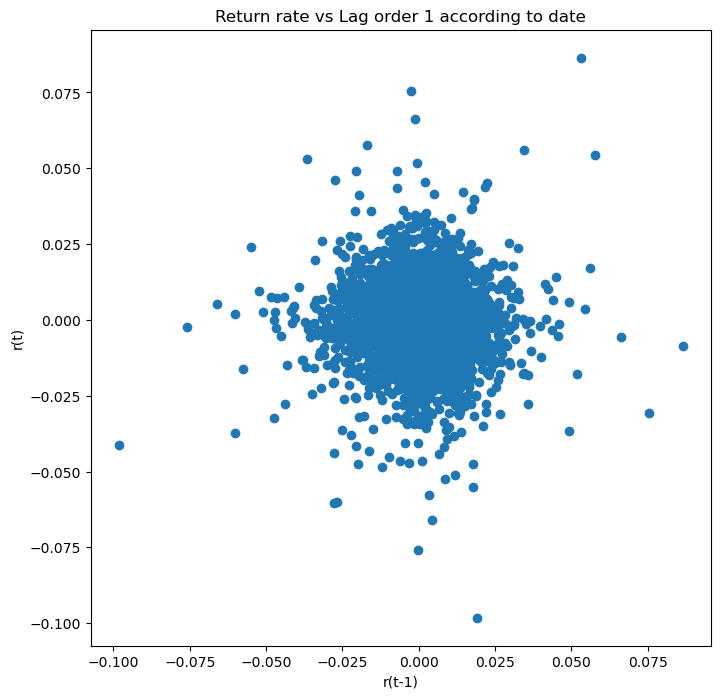

In [82]:
plt.figure(figsize=(8, 8))
plt.scatter(x=r_t[1:], y=r_t[:-1])
plt.title('Return rate vs Lag order 1 according to date')
plt.xlabel('r(t-1)')
plt.ylabel('r(t)')
plt.show()

Text(0, 0.5, 'frequency')

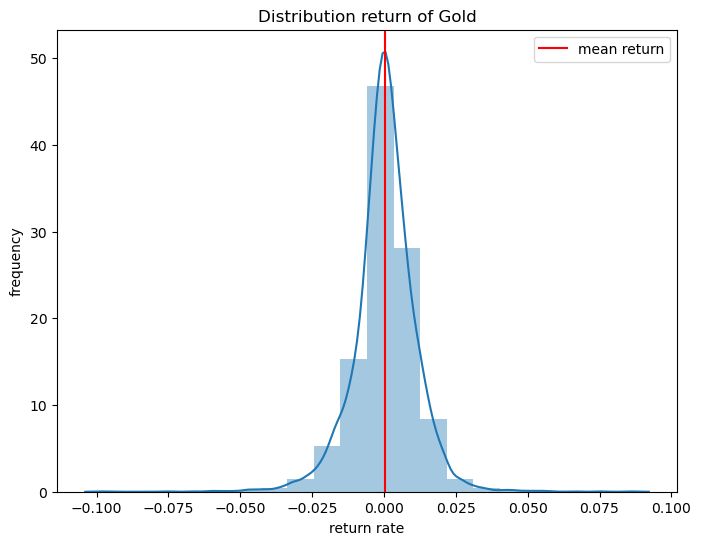

In [87]:
plt.figure(figsize = (8, 6))
sns.distplot(r_t, bins = 20)
plt.axvline(x=mean, label='mean return', c='red')
plt.title('Distribution return of Gold')
plt.legend()
plt.xlabel('return rate')
plt.ylabel('frequency')

In [78]:
scaled_data = df[["Close"]]
scaled_data = scaled_data.fillna(0).to_numpy()
len(scaled_data)

6024

In [79]:
splitting_len = int(len(scaled_data)*0.8)
y_train = scaled_data[:splitting_len]
y_test = scaled_data[splitting_len:]

C:\Users\LAP13398-local\anaconda3\envs\thuantran\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


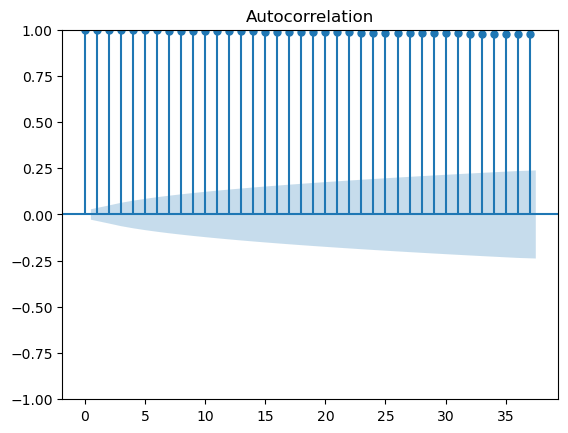

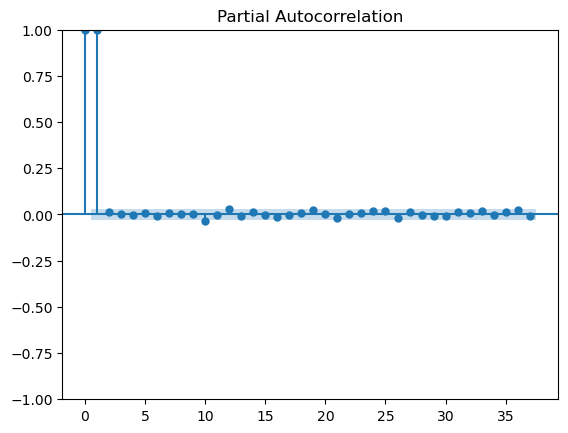

In [81]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_original = plot_acf(y_train)
pacf_original = plot_pacf(y_train)

In [119]:
datetime.strftime(datetime.today(), '%Y-%m-%d')

'2024-11-08'

In [88]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(y_train)
print(f'p-value: {adf_test[1]}') # Là chuổi dừng

p-value: 0.705803487182284


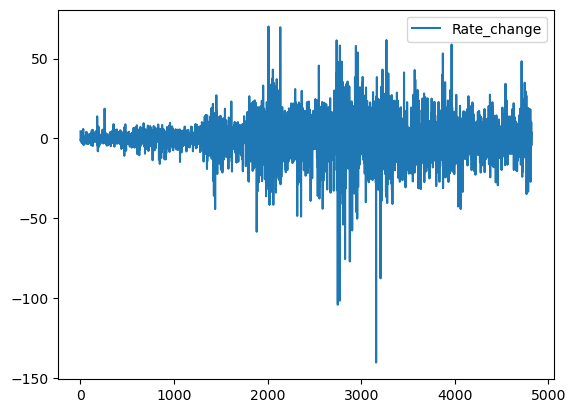

In [89]:
df_train_diff = pd.DataFrame(y_train).diff().dropna()
df_train_diff.plot()
plt.legend(["Rate_change"]);

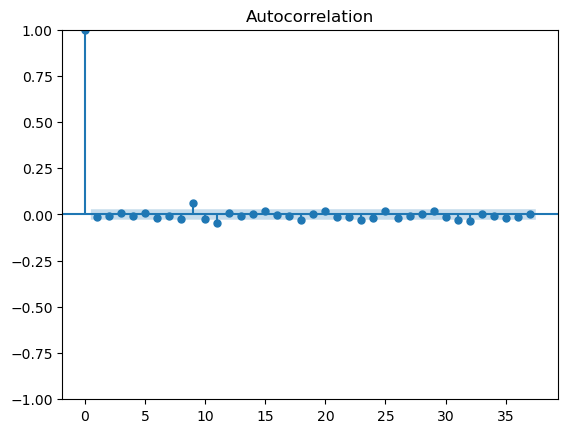

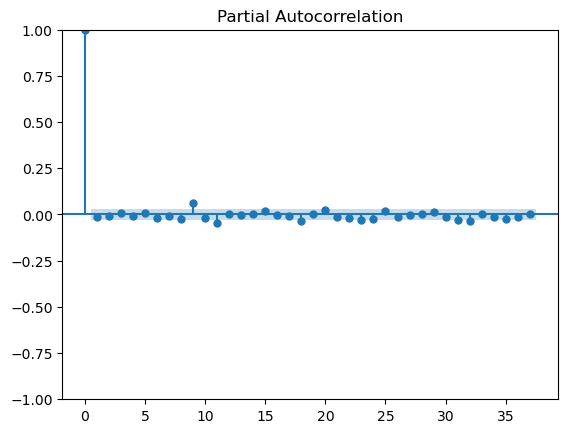

In [90]:
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

In [91]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}') # p_value < 0.05 nên là chuỗi dừng

p-value: 0.0


In [92]:
# Fit your model
model1 = pm.auto_arima(y_train, stepwise=False, seasonal=False)

<Figure size 640x480 with 0 Axes>

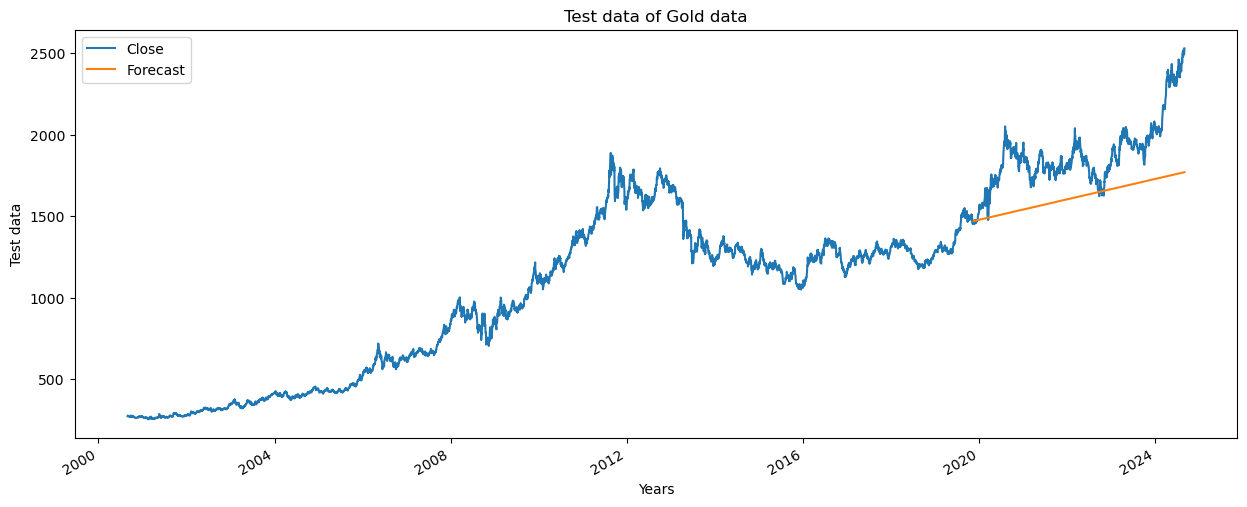

In [94]:
# predict
forecast_test_auto = model1.predict(n_periods=len(y_test))
df['Forecast'] = [None]*len(y_train) + list(forecast_test_auto)

plot_graph((15,6), df, 'Test data')

In [97]:
mae = mean_absolute_error(y_test, forecast_test_auto)
mape = mean_absolute_percentage_error(y_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(y_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 260.9697669556217
mape - auto: 0.13280351982455763
rmse - auto: 301.2201329913753


### Kết luận: 
Mô hình LSTM cho kết quả rsme là 35.77, nhỏ hơn so với mô hình ARIMA (rmse của mô hình ARIMA là 301.22).
Như vậy, mô hình LSTM cho kết quả dự báo tốt hơn so với mô hình ARIMA, ta lựa chọn LSTM để làm mô hình dự báo.